<h1>Recreating Results of Syracuse Paper</h1>

In [2]:
import sys  
sys.path.insert(1, '../src')

In [87]:
import os
import numpy as np
import pandas as pd

from utils import * 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, auc, roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, accuracy_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np 
import os 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor, XGBClassifier

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
df = pd.read_csv("../data/transformed/watermain_breaks_train.csv")
val = pd.read_csv("../data/transformed/watermain_breaks_validation.csv")
test = pd.read_csv("../data/transformed/watermain_breaks_test.csv")

<h2>Prepare Data</h2>

2015-2018 is our target period

Outcome: if the pipe will breaks in the next 3 years

In [6]:
#looking from 2015 trying to predict next 3 years
CUTOFF = pd.to_datetime('01-01-2016')
TEST_VAL_CUTOFF = pd.to_datetime('01-01-2019')

In [7]:
df = process_date_cols(df, CUTOFF)

In [8]:
cols = ['PressureSy', 'STATUS', 'MATERIAL', 'SUBTYPE']
df = svm_data_transform_pipeline(df, CUTOFF, cols)

In [9]:
val = process_date_cols(val, TEST_VAL_CUTOFF)
val = svm_data_transform_pipeline(val, TEST_VAL_CUTOFF, cols)


test = process_date_cols(test, TEST_VAL_CUTOFF)
test = svm_data_transform_pipeline(test, TEST_VAL_CUTOFF, cols)

<h3>Handling some differences in dummy variables</h3>

In [10]:
all_cols = list(test.columns) 
all_cols.extend(list(df.columns))
all_cols.extend(list(val.columns))

for col in all_cols: 
    if col not in list(test.columns):
        test[col] = 0
    if col not in list(val.columns):
        val[col] = 0
    if col not in list(df.columns):
        df[col] = 0

<h2>Split</h2>

In [156]:
X_train = df.drop(columns = ['will_break'])
y_train = df['will_break']

X_test = test.drop(columns = ['will_break'])
y_test = test['will_break']

X_val = val.drop(columns = ['will_break'])
y_val = val['will_break']

In [116]:
pd.co

,LENGTH,DIAMETER,installation_year,n_previous_breaks,delta_installation_to_first_break,delta_installation_to_most_recent_break,GRA,NEH,NEHEPRZ,NEHWPRZ,...,CU,GAL,HDPE,UNK,Other,NEDPRZ,OTH,ST,STL,Raw Water
146,10.0,12.0,2018,0,92,92,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
147,152.0,12.0,2018,0,92,92,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
148,7.0,8.0,2018,0,204,204,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
149,8.0,6.0,2018,0,306,306,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
150,5.0,6.0,2018,0,334,334,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,669.0,16.0,1970,1,17428,17428,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
677,831.0,6.0,1950,0,25202,25202,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
678,1259.0,8.0,1966,1,18683,18683,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
679,510.0,4.0,1886,0,48577,48577,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
np.where(y_train == 1)[0].shape

(157,)

In [102]:
pd.to_datetime(X_test['installation_year'], unit='D').dt.year
# X_test['installation_year'] = X_test['installation_year'].dt.year

716     1975
717     1975
718     1975
719     1975
720     1975
        ... 
3851    1975
3852    1975
3853    1975
3854    1975
3855    1975
Name: installation_year, Length: 3073, dtype: int32

<h2>Scaling</h2>

In [113]:
numeric_cols = list(X_train.columns)
numeric_cols.remove('installation_year')

In [114]:
numeric_cols = list(X_train.columns)
numeric_cols.remove('installation_year')
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
    ]
)

In [121]:
# concat xval and x test
X_val_test = pd.concat([X_val, X_test], axis = 0)
y_val_test = pd.concat([y_val, y_test], axis = 0)
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC(C=15, class_weight='balanced',  kernel='rbf'))]
)
# probability =True
clf.fit(X_train, y_train)
preds = clf.predict(X_val_test)
print(classification_report(y_val_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3562
           1       0.03      0.64      0.06        36

    accuracy                           0.82      3598
   macro avg       0.51      0.73      0.48      3598
weighted avg       0.99      0.82      0.89      3598



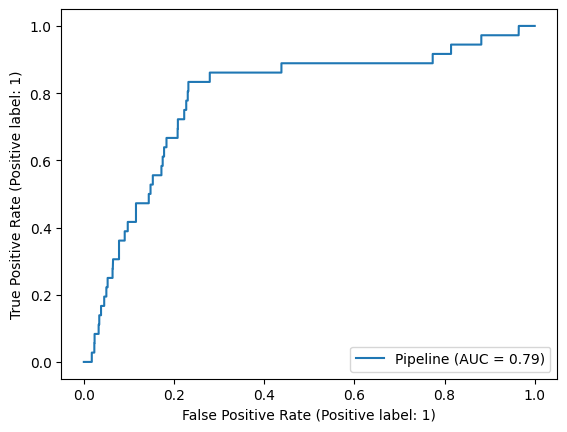

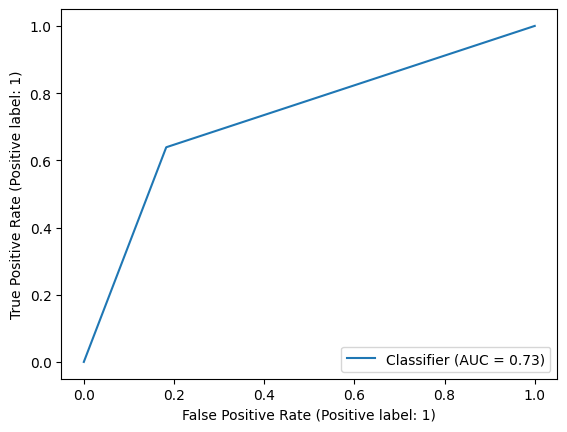

In [123]:
RocCurveDisplay.from_estimator(clf, X_val_test, y_val_test)
RocCurveDisplay.from_predictions(y_val_test, preds)

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])
X_val_scaled = scaler.transform(X_val[numeric_cols])

X_train = np.concatenate([X_train_scaled, np.array(X_train['installation_year'].values).reshape(-1, 1)], axis = 1)
X_test = np.concatenate([X_test_scaled, np.array(X_test['installation_year'].values).reshape(-1, 1)], axis = 1)
X_val = np.concatenate([X_val_scaled, np.array(X_val['installation_year'].values).reshape(-1, 1)], axis = 1)

In [251]:
models = [
  

    ("Logistic Regression Classification", LogisticRegression(), {'model__C': [0.05, 0.005, 0.1, 0.25, 0.5, 1, 2, 5], 'model__max_iter': [1000], 'model__intercept_scaling': [1, 2, 3, 4, 5], 'model__class_weight': ['balanced', None], 'model__random_state': [13]}),
    # ("SVC - C5", SVC(C = 5, class_weight='balanced'), {'model__C': [5, 10, 15], 'model__gamma': ['scale', 'auto']}),
    # ("SVC2 - C 20", SVC(C = 20, class_weight='balanced'), {'model__C': [5, 10, 15], 'model__gamma': ['scale', 'auto']}),
    # ("SVC3 - C 15", SVC(C = 15, class_weight='balanced'), {'model__C': [5, 10, 15], 'model__gamma': ['scale', 'auto']}),
    # ("SVC4 - C1", SVC(C = 1, class_weight='balanced'), {'model__C': [5, 10, 15], 'model__gamma': ['scale', 'auto']}),
    # ("SVC5 - C10", SVC(C = 10, class_weight='balanced'), {'model__C': [5, 10, 15], 'model__gamma': ['scale', 'auto']}),
    ("SVC6", SVC(), {'model__C': [5, 7, 10, 12, 15, 18, 20], 'model__gamma': ['scale', 'auto'], 'model__class_weight': ['balanced'], 'model__random_state': [13]}),
    # ("Decision Tree Regression", DecisionTreeClassifier(), {'model__max_depth':[None,2, 5]}),
    ("Random Forest Classification", RandomForestClassifier(), {'model__n_estimators': [75, 100,125, 150,200], 'model__max_depth':[None, 2, 3, 4, 5], 'model__min_samples_split': [2, 3, 4], 'model__max_features': ['sqrt', 'log2', 10, 12, 15, 17], 'model__random_state': [13]}), # 'model__class_weight': ['balanced', None]}),
    # ("Random Forest Classification2", RandomForestClassifier(min_samples_split = 3,  n_estimators=75), {'model__n_estimators': [100,150,200]}), 

    #'model__class_weight': ['balanced']

    # ("Gradient Boosting Classification", GradientBoostingClassifier(n_estimators=440, max_depth=5, learning_rate=0.012, random_state=0, max_features='sqrt'), {'model__n_estimators': [100,150,200]}),
    ("Gradient Boosting Classification", GradientBoostingClassifier(), {'model__n_estimators': [100, 150,200, 300, 450, 500], 'model__max_depth': [3, 5, 4, 6,7], 'model__learning_rate': [0.01, 0.025, .05, 0.75, 0.1], 'model__max_features': ['sqrt', 'log2'], 'model__random_state': [13], 'model__min_samples_split': [2, 3, 4]}),
    # ("Gradient Boosting Classification2", GradientBoostingClassifier( n_estimators=100, max_depth=7, learning_rate=0.2, random_state=0, max_features='sqrt'), {'model__n_estimators': [100,150,200]}),
    # ("Gradient Boosting Classification3", GradientBoostingClassifier( n_estimators=375, max_depth=3, learning_rate=0.02, random_state=0, max_features=2), {'model__n_estimators': [100,150,200]}),
    # ('xgb', XGBClassifier(), {'model__n_estimators': [100,150,200]}),

    # ("K-Nearest Neighbors Classification", KNeighborsClassifier(), {'model__n_neighbors': [3,5]}),
    #("Neural Network Classification", MLPClassifier(max_iter=1000)),  # Specify appropriate hyperparameters

    
]

In [110]:
# concat xval and x test
X_val_test = np.concatenate([X_val, X_test], axis = 0)
y_val_test = np.concatenate([y_val, y_test], axis = 0)

class 0: (19405, 33)
class 1: (157, 33)
total class of 1 and0: will_break
0    1256
1     157
Name: count, dtype: int64


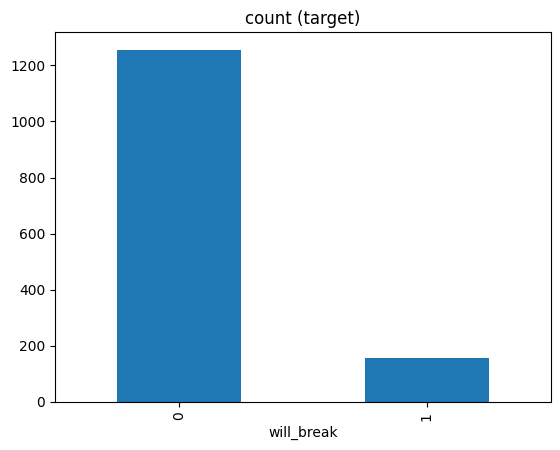

In [165]:
# class count
class_count_0, class_count_1 = df['will_break'].value_counts()

# Separate class
class_0 = df[df['will_break'] == 0]
class_1 = df[df['will_break'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
class_0_under = class_0.sample(class_count_1*8)

test_under = pd.concat([class_0_under, class_1], axis=0)
print("total class of 1 and0:",test_under['will_break'].value_counts()) # plot the count after under-sampling
test_under['will_break'].value_counts().plot(kind='bar', title='count (target)')

y_train = test_under['will_break']
X_train = test_under.drop(columns = ['will_break'])

X_val_test = pd.concat([X_val, X_test], axis = 0)
y_val_test = pd.concat([y_val, y_test], axis = 0)

total class of 1 and0: will_break
0    1256
1     157
Name: count, dtype: int64


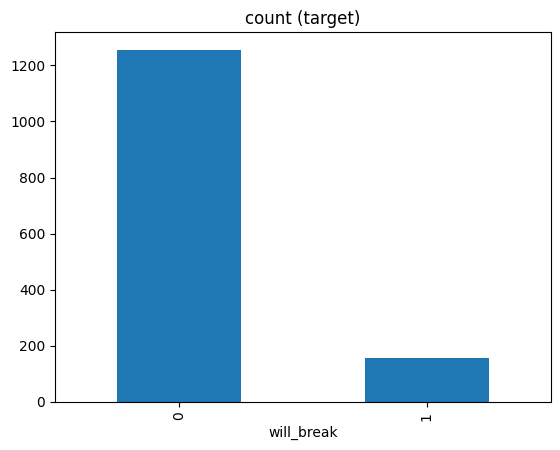

In [152]:
class_0_under = class_0.sample(class_count_1*8)

test_under = pd.concat([class_0_under, class_1], axis=0)
print("total class of 1 and0:",test_under['will_break'].value_counts()) # plot the count after under-sampling
test_under['will_break'].value_counts().plot(kind='bar', title='count (target)')

y_train = test_under['will_break']
test_under = test_under.drop(columns = ['will_break'])
numeric_cols = list(test_under.columns)
numeric_cols.remove('installation_year')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(test_under[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])
X_val_scaled = scaler.transform(X_val[numeric_cols])

X_train = np.concatenate([X_train_scaled, np.array(test_under['installation_year'].values).reshape(-1, 1)], axis = 1)
X_test = np.concatenate([X_test_scaled, np.array(X_test['installation_year'].values).reshape(-1, 1)], axis = 1)
X_val = np.concatenate([X_val_scaled, np.array(X_val['installation_year'].values).reshape(-1, 1)], axis = 1)
X_val_test = np.concatenate([X_val, X_test], axis = 0)
y_val_test = np.concatenate([y_val, y_test], axis = 0)

In [33]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 19405, 1: 157})
Resample dataset shape Counter({0: 19405, 1: 19405})


Logistic Regression Classification
Fitting 3 folds for each of 80 candidates, totalling 240 fits


best params {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__intercept_scaling': 1, 'model__max_iter': 1000, 'model__random_state': 13}
auc 0.8066239316239316
f1 0.07733333333333334
SVC6
Fitting 3 folds for each of 14 candidates, totalling 42 fits
best params {'model__C': 7, 'model__class_weight': 'balanced', 'model__gamma': 'auto', 'model__random_state': 13}
auc 0.7745024642834862
f1 0.07658321060382917
Random Forest Classification
Fitting 3 folds for each of 450 candidates, totalling 1350 fits
best params {'model__max_depth': 5, 'model__max_features': 17, 'model__min_samples_split': 3, 'model__n_estimators': 200, 'model__random_state': 13}
auc 0.6433729490298833
f1 0.19298245614035087
Gradient Boosting Classification
Fitting 3 folds for each of 900 candidates, totalling 2700 fits
best params {'model__learning_rate': 0.025, 'model__max_depth': 4, 'model__max_features': 'sqrt', 'model__min_samples_split': 4, 'model__n_estimators': 450, 'model__random_state': 13}
auc 0.62779

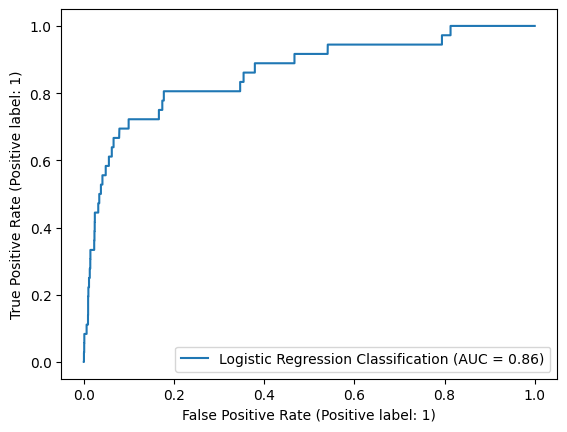

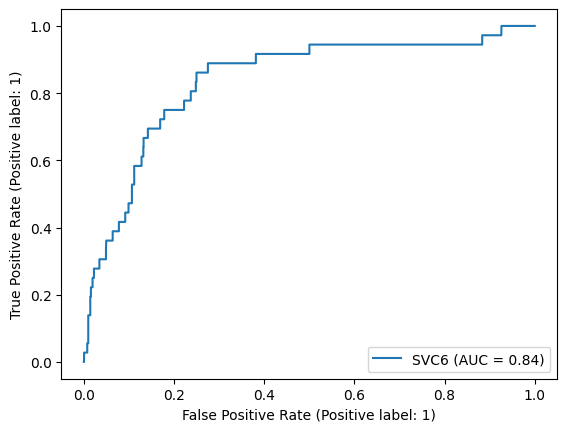

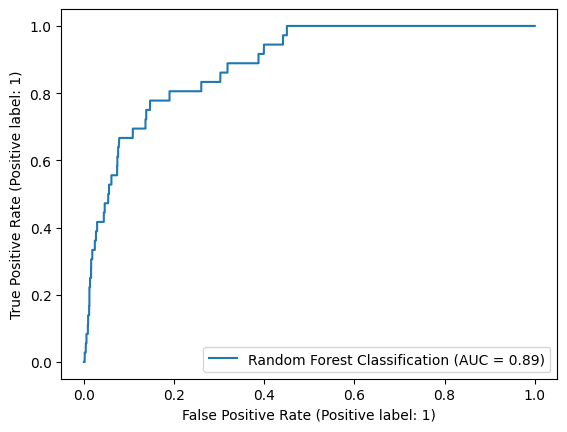

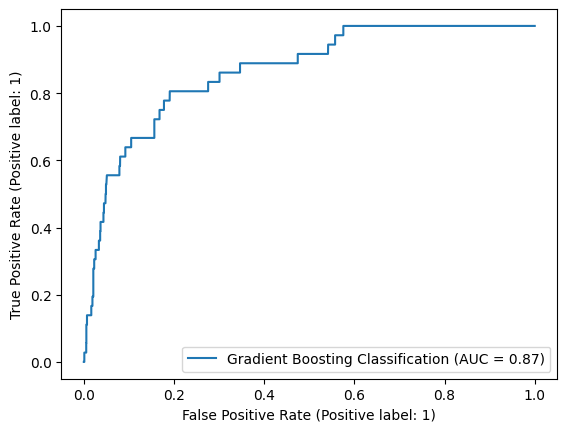

In [252]:
new_model_lists = []
for model in models:
  
    name = model[0]
    params =model[2]
    print(model[0])
    model = model[1]
    numeric_cols = list(df.columns)
    numeric_cols.remove('installation_year')
    numeric_cols.remove('will_break')
    # numeric_transformer = Pipeline(
    #     steps=[("scaler", StandardScaler())]
    # )


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_cols),
            ("year", 'passthrough', ['installation_year'])
        ]
    )
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ('model', model)])
    #model.fit(trainX_prepared, trainY)
    grids =  GridSearchCV(pipe, param_grid=params, scoring=['f1', 'roc_auc'], cv=3, refit='f1', verbose=1, n_jobs=-1)
    grids.fit(X_train, y_train)
    # , 'roc_auc'
    #print('train result', result['test_score'])
    print('best params', grids.best_params_)
    # print('mean_score:', -np.mean(result['test_score']))
    y_preds = grids.best_estimator_.predict(X_val_test)
    new_model_lists.append((name, grids.best_estimator_))
    print('auc', roc_auc_score(y_val_test, y_preds))
    print('f1', f1_score(y_val_test, y_preds))
    RocCurveDisplay.from_estimator(grids.best_estimator_, X_val_test, y_val_test, name=name)

Logistic Regression Classification
auc 0.6451977665481315


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3562
           1       0.17      0.31      0.22        36

    accuracy                           0.98      3598
   macro avg       0.58      0.65      0.60      3598
weighted avg       0.98      0.98      0.98      3598

f1 0.21782178217821782
SVC - C5
auc 0.7818953147420301
              precision    recall  f1-score   support

           0       1.00      0.67      0.81      3562
           1       0.03      0.89      0.05        36

    accuracy                           0.68      3598
   macro avg       0.51      0.78      0.43      3598
weighted avg       0.99      0.68      0.80      3598

f1 0.05220228384991844
SVC2 - C 20
auc 0.789888639341194
              precision    recall  f1-score   support

           0       1.00      0.66      0.80      3562
           1       0.03      0.92      0.05        36

    accuracy                           0.67      3598
   macro avg    

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


auc 0.649681826689126
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3562
           1       0.09      0.33      0.14        36

    accuracy                           0.96      3598
   macro avg       0.54      0.65      0.56      3598
weighted avg       0.98      0.96      0.97      3598

f1 0.14201183431952663


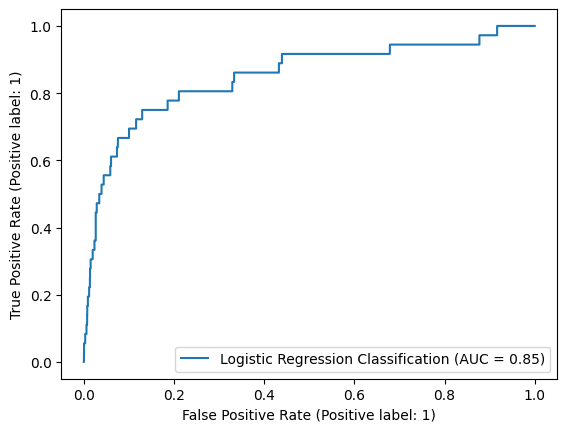

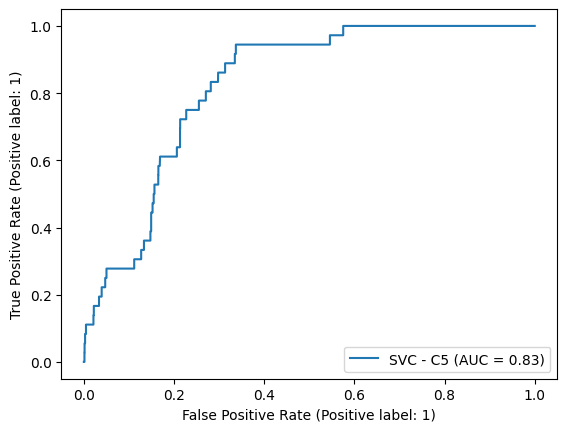

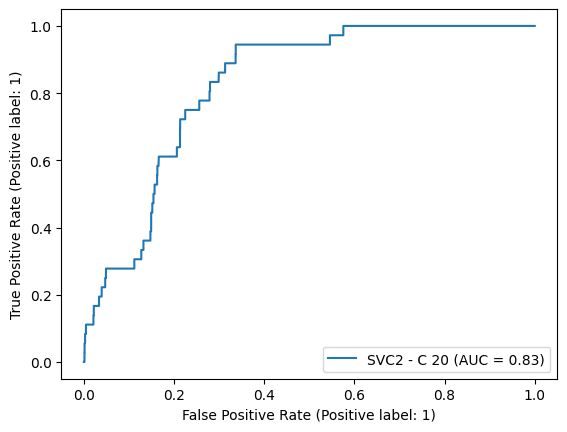

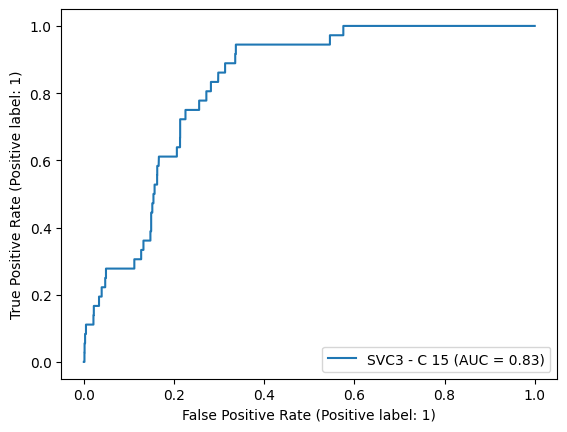

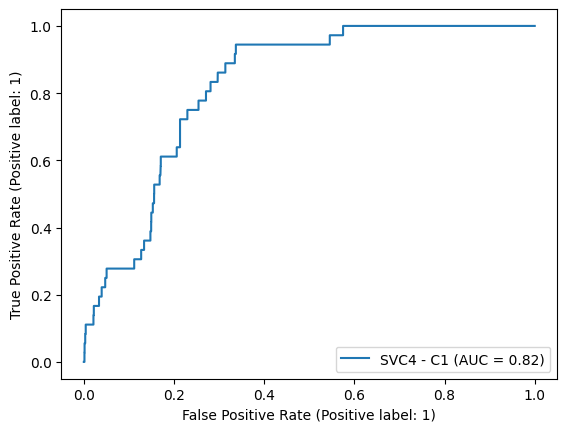

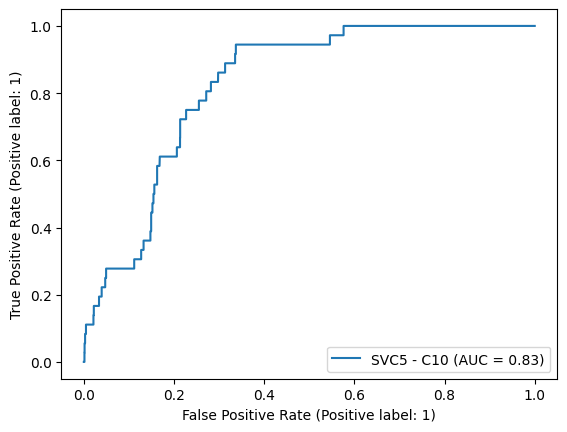

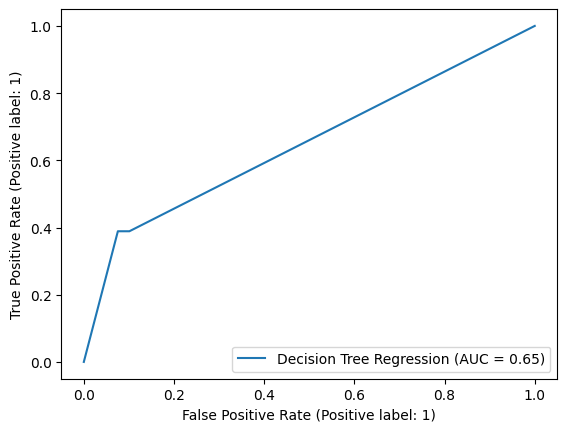

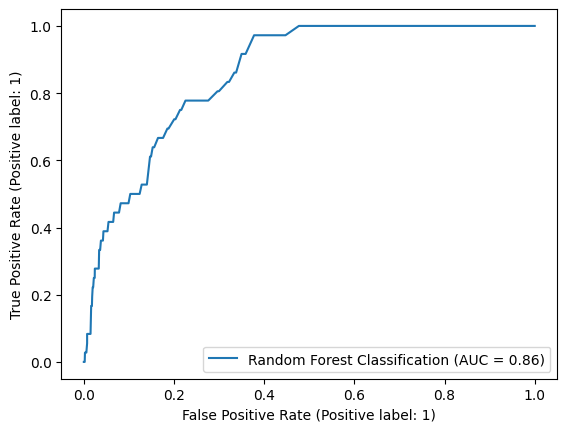

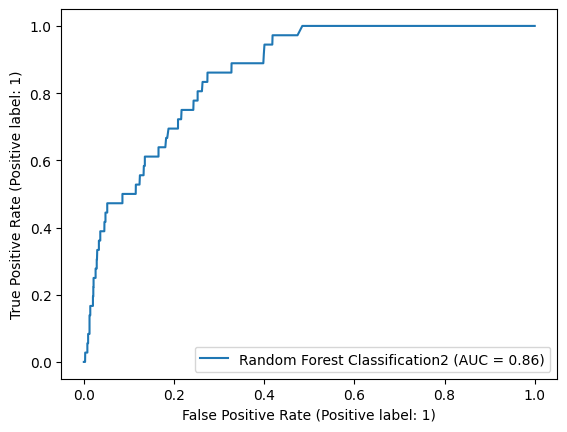

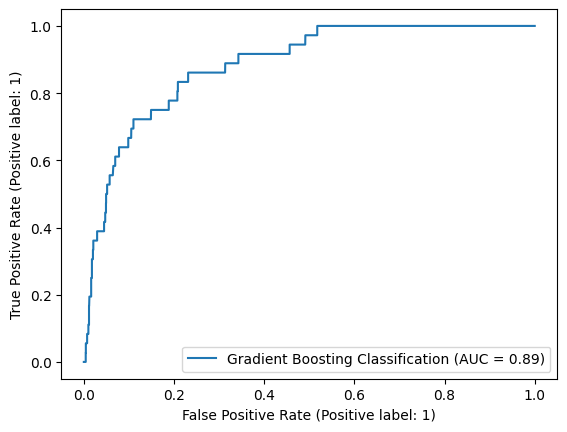

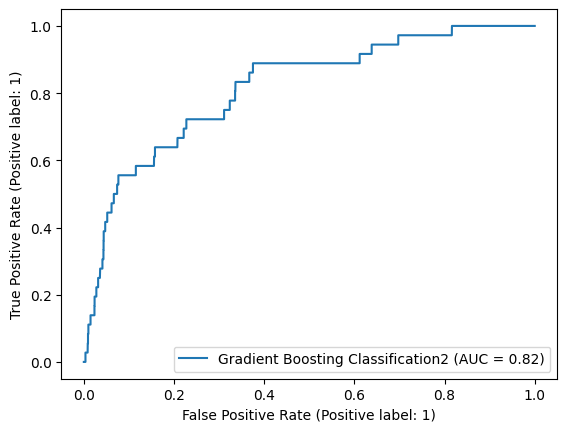

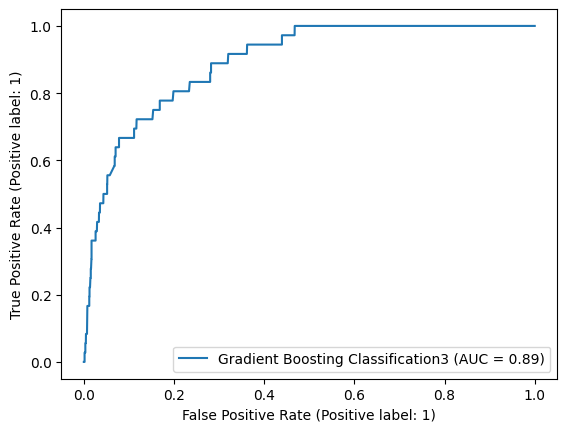

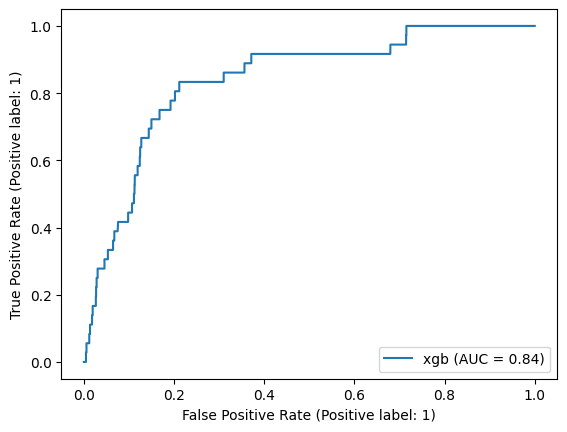

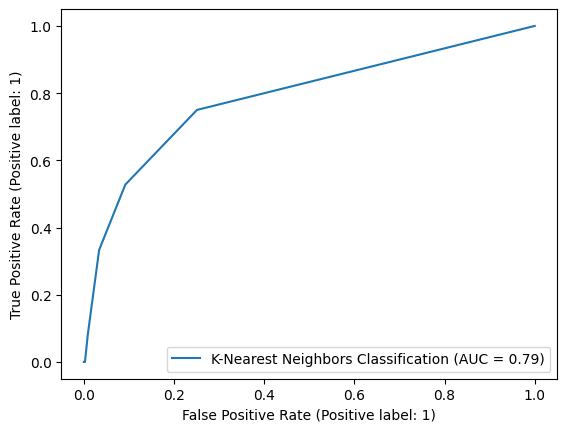

In [127]:
new_model_lists = []
for model in models:
    
    name = model[0]
    print(model[0])
    model = model[1]
    # pipe = Pipeline([('scaler', StandardScaler()), (name, model)])
    model.fit(X_train, y_train)
    # model.fit(x_smote, y_smote)
    # grids =  GridSearchCV(pipe, param_grid={}, scoring='f1', cv=3)
    # grids.fit(X, y)

    test_pred = model.predict(X_val_test)
    new_model_lists.append((name, model))
    # print('train result', result['test_score'])
    # grids.best_score_
    # print('mean_score:', -np.mean(result['test_score']))
    # y_preds = grids.best_estimator_.predict(X_test)
    print('auc', roc_auc_score(y_val_test, test_pred))
    # RocCurveDisplay.from_predictions(y_val_test, test_pred, name=name)
    # RocCurveDisplay.from_estimator(grids.best_estimator_, X_val_test, y_val_test, name=name)
    RocCurveDisplay.from_estimator(model, X_val_test, y_val_test, name=name)
    print(classification_report(y_val_test, test_pred))
    print('f1', f1_score(y_val_test, test_pred))
    
   

In [132]:
list(df.columns)

['LENGTH',
 'DIAMETER',
 'will_break',
 'installation_year',
 'n_previous_breaks',
 'delta_installation_to_first_break',
 'delta_installation_to_most_recent_break',
 'GRA',
 'NEDPRZ',
 'NEH',
 'NEHEPRZ',
 'NEHWPRZ',
 'OTH',
 'SCIO',
 'SHE',
 'WH',
 'WNPRZ',
 'IS',
 'CI',
 'CU',
 'DI',
 'GAL',
 'HDPE',
 'PVC',
 'RC',
 'ST',
 'STL',
 'UNK',
 'Hydrant Lead',
 'Other',
 'Raw Water',
 'Transmission Main',
 'C909']

In [246]:
gb_ft_imp = new_model_lists[3][1].named_steps['model'].feature_importances_

In [247]:
df_copy = df.copy().drop(columns = ['will_break'])

In [248]:
# sortedgb = sorted(list(zip(list(df_copy.columns), new_model_lists[11][1].feature_importances_)), key = lambda x: x[1], reverse = True)
sortedgb = sorted(list(zip(list(df_copy.columns), gb_ft_imp)), key = lambda x: x[1], reverse = True)

In [249]:
features = [x[0] for x in sortedgb]
importances = [x[1] for x in sortedgb]

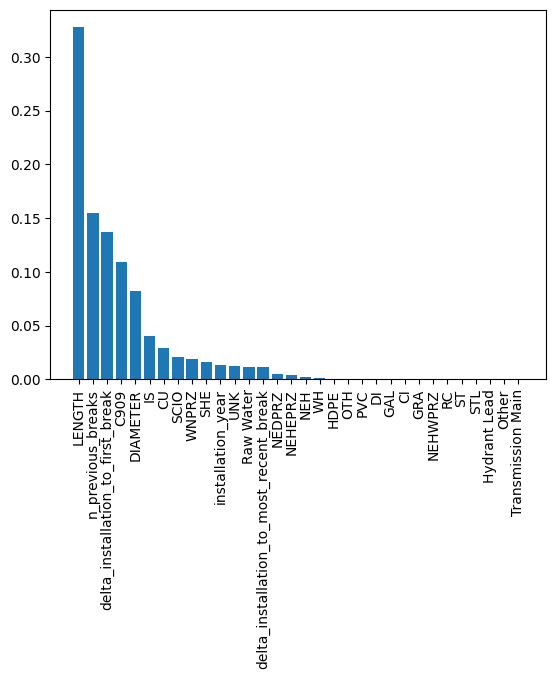

In [250]:
plt.bar(features, importances)
plt.xticks(rotation=90)
plt.show()

In [206]:
X_val_test.columns

Index(['LENGTH', 'DIAMETER', 'installation_year', 'n_previous_breaks',
       'delta_installation_to_first_break',
       'delta_installation_to_most_recent_break', 'GRA', 'NEH', 'NEHEPRZ',
       'NEHWPRZ', 'SCIO', 'SHE', 'WH', 'WNPRZ', 'IS', 'C909', 'CI', 'DI',
       'PVC', 'RC', 'Hydrant Lead', 'Transmission Main', 'CU', 'GAL', 'HDPE',
       'UNK', 'Other', 'NEDPRZ', 'OTH', 'ST', 'STL', 'Raw Water'],
      dtype='object')

In [207]:
new_model_lists[4][1].named_steps['model'].predict(X_val_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 32 features, but GradientBoostingClassifier is expecting 31 features as input.

<h2>Cross Validation</h2>

In [21]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [22]:
svc.score(X_test, y_test)

0.9908883826879271

In [26]:
pred = svc.predict(X_val)

In [28]:
print(classification_report(pred, y_val))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       525
           1       0.00      0.00      0.00         0

    accuracy                           0.98       525
   macro avg       0.50      0.49      0.50       525
weighted avg       1.00      0.98      0.99       525



/Users/haleyjohnson/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haleyjohnson/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haleyjohnson/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
f1_score(pred, y_val)

0.0

In [33]:
auc(pred, y_val)

0.0